In [26]:
from scipy import interpolate
import numpy as np
import pandas as pd
import pybamm
from typing import List, Dict, Union
import matplotlib.pyplot as plt

In [17]:
class Resistance():
    def __init__(self, ohm):
        self._r_ohm = ohm
        self.voltage = 0
        
    def step(self, I, dt):
        self.voltage = I * self._r_ohm
        return self.voltage
    

class ResistanceCapacitance():
    def __init__(self, ohm, farad, v_init=0.0):
        self._r_ohm = ohm
        self._c_farad = farad
        self._tau = self._r_ohm * self._c_farad
        self.voltage = v_init
        
    def _dVdt(self, I, V):
        calculated_v = I * self._r_ohm
        return (calculated_v - V) / self._tau
    
    def step(self, I, dt):
        self.voltage += dt * self._dVdt(I, self.voltage)
        return self.voltage

In [18]:
class BatteryCell():
    def __init__(self,
                 batCurve,
                 nominalV=3.7,
                 scaleV=1.0,
                 scaleAh=1.0,
                 Vinit=None,
                 usedAh=None,
                 lv_cut_off=2.3,
                 uv_cut_off=4.8):
        # Terminal voltage as a function of capacity
        self._TV_fun_of_Ah = interpolate.interp1d(scaleAh * batCurve[0],
                                                  scaleV * batCurve[1],
                                                  fill_value=(batCurve[1, 0], batCurve[1, -1]))
        
        # Capacity as a function of terminal voltage
        self._Ah_fun_of_TV = interpolate.interp1d(scaleV * batCurve[1],
                                                  scaleAh * batCurve[0],
                                                  fill_value=(batCurve[0, 0], batCurve[0, -1]))
        self.maxAh = scaleAh * batCurve[0, -1]
        self._nomV = nominalV
        self._scaleV = scaleV
        self._scaleAh = scaleAh
        self._lower_voltage_cut_off = lv_cut_off
        self._upper_voltage_cut_off = uv_cut_off
        
        if Vinit is None and usedAh is None:
            self.V = nominalV
            self.usedAh = self._Ah_fun_of_TV(self.V)
        elif Vinit is None:
            self.usedAh = usedAh
            # The terminal voltage of the battery is calculated by the capacity of the battery
            self.V = self._TV_fun_of_Ah(self.usedAh)
        elif usedAh is None:
            self.V = Vinit
            # Capacity of the battery is calculated using the Terminal voltage
            self.usedAh = self._Ah_fun_of_TV(self.V)
        else:
            # This is used to minimize the error caused by providing not corresponding values for Vinit and usedAh
            raise ValueError('Vinit and usedAh cannot be specified at the same time!')          
    
    
    def retrieveSOCByV(self, V):
        return 1 - (self._Ah_fun_of_TV(V) / self.maxAh)
    
    
    def step(self, I, dt):
        self.usedAh += dt*I*(1/3600)
        
        if self.usedAh >= self.maxAh:
            # A Battery can't be fully discharged that's why we set the voltage to lower voltage cut_off
            self.V = self._lower_voltage_cut_off
            self.usedAh = self._Ah_fun_of_TV(self.V)
        elif self.usedAh <= 0:
            # A battery can't be fully charged that's why we set the voltage to upper voltage cut_off
            self.V = self._upper_voltage_cut_off
            self.usedAh = self._Ah_fun_of_TV(self.V)
        else:
            self.V = self._TV_fun_of_Ah(self.usedAh)
            
        return self.V

In [19]:
class BatteryCellWithLosses():
    def __init__(self, battery_cell_instance, lossers=[]):
        self.cell = battery_cell_instance
        self._lossers = lossers
        self.V = self.cell.V
        
    def step(self, I, dt):
        v_cell = self.cell.step(I, dt)
        v_loss = sum([losser.step(I, dt) for losser in self._lossers])
        self.V = v_cell - v_loss
        
        return self.V
    
    def getSOC(self):
        return self.cell.retrieveSOCByV(self.V)

In [36]:
def simulate(battery: BatteryCellWithLosses, current_delta_list: List[float], records: List[Dict]):
    
    for current_delta in current_delta_list:
        voltage= battery.step(current_delta, 30)
        records.append({
            "current_delta": current_delta,
            "voltage": voltage,
            "soc": battery.getSOC()
        })

<AxesSubplot:>

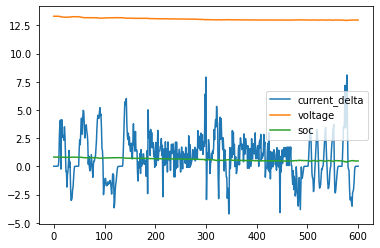

In [37]:
# import drive cycle from file
drive_cycle = pd.read_csv(f"{pybamm.__path__[0]}/input/drive_cycles/US06.csv", comment="#", header=None).to_numpy()

cellAh = 12
r_ohm_internal = 4.2e-3 # used for debugging
R0 = 0.5 * r_ohm_internal
R1 = 0.2 * r_ohm_internal
C1 = 60e3
R2 = 0.3 * r_ohm_internal
C2 = 60e3
bat_curve = np.array([
    [x * cellAh for x in [0, 0.09, 0.14, 0.17, 0.2, 0.3, 0.4, 0.7, 0.9, 0.99, 1, 1]],
    [14.6, 13.6, 13.4, 13.3, 13.2, 13.1, 13, 12.9, 12.8, 12.5, 12, 10]
])

current_delta_list = drive_cycle[:, 1]
records = []  # log of some infos for later analysis

battery = BatteryCellWithLosses(
    BatteryCell(bat_curve, nominalV=13, Vinit=13.3, lv_cut_off=10.05, uv_cut_off=14.55),
    lossers=[Resistance(R0), ResistanceCapacitance(R1, C1), ResistanceCapacitance(R2, C2)])

simulate(battery, current_delta_list, records)
result = pd.DataFrame(records)
result.plot()

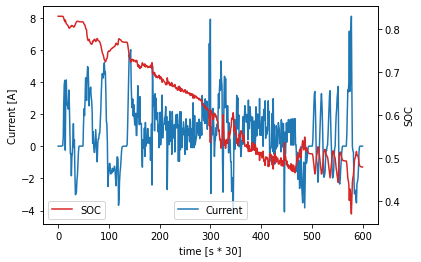

In [53]:
# Plot solar
fig, ax1 = plt.subplots()
ax1.set_ylabel("Current [A]")
ax1.set_xlabel('time [s * 30]')
result['current_delta'].plot(color="tab:blue", ax=ax1, label='Current')
ax1.legend(loc='lower center')

# Plot taxis
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel("SOC")
result['soc'].plot(color="tab:red", ax=ax2, label='SOC')
ax2.legend(loc='lower left')
fig.savefig('ideal_battery_soc_current.png')

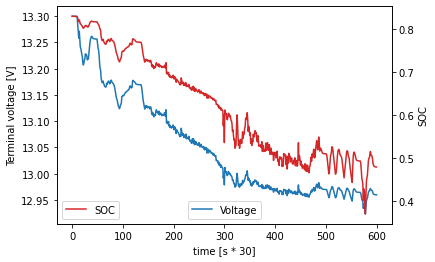

In [54]:
# Plot solar
fig, ax1 = plt.subplots()
ax1.set_ylabel("Terminal voltage [V]")
ax1.set_xlabel('time [s * 30]')
result['voltage'].plot(color="tab:blue", ax=ax1, label='Voltage')
ax1.legend(loc='lower center')

# Plot taxis
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel("SOC")
result['soc'].plot(color="tab:red", ax=ax2, label='SOC')
ax2.legend(loc='lower left')
fig.savefig('ideal_battery_soc_voltage.png')